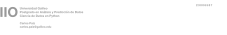

In [52]:
# This allows to show images in the notebook
from IPython.display import SVG

SVG(filename='../res/iio-header-w.svg')

# Project I

## Introduction

The goal of this project is to analyze house prices using a uni-variate linear regression model. We will train this model on a dataset that includes information about different features of houses, including square footage, number of rooms, and lot frontage.

To achieve our goal, we will explore the data using popular libraries such as scikit-learn. We will manually develop and implement the linear regression model, and compare its performance with the model trained using scikit-learn. This will help us determine which approach yields better predictions.

Through this project, we aim to gain a better understanding of how linear regression models work and how they can be used for analyzing real-world data. Our ultimate goal is to be able to accurately predict house prices based on their features, and provide valuable insights for real estate professionals and potential buyers alike.

## Regression fundamentals

*Regression is where models predict a number.<sup>1</sup>*

Supervised machine learning techniques involve training a model to operate on a set of features and predict a label using a dataset that includes some already-known label values. The training process fits the features to the known labels to define a general function that can be applied to new features for which the labels are unknown, and predict them. We can think of this function like this, in which y represents the label we want to predict and x represents the features the model uses to predict it.

## Setting up the environment

In [53]:
# Setting up the environment
import pandas as pd
from experiment import PreprocessData
from experiment import CustomModel
from plotter import DataPlotter

%matplotlib inline

## Exploring the data

Exploring the data is a crucial first step in training any machine learning model. The objective of data exploration is to identify the relationships between various attributes, specifically any correlation between the features and the label that the model will predict. This may involve addressing data issues such as missing values, errors or outliers, creating new feature columns through feature engineering, normalizing numeric features to ensure they are on the same scale, and encoding categorical features as numeric indicators.

Let's start by loading the House Prices data:

In [54]:
data = PreprocessData()

house_prices = data.load_data('data/proyecto_training_data.npy')

Data loaded!


The data consists of the following information:

* **SalePrice**: the property's sale price in dollars. This is the target variable that you're trying to predict.
* **OverallQual**: Overall material and finish quality, rates the overall material and finish of the house.
* **FloorSquareFeet**: First Floor square feet.
* **TotalRooms**: Total rooms above grade (does not include bathrooms)
* **YearBuilt**: Original construction date.
* **LotFrontage**: Linear feet of street connected to property.

In this dataset, **SalePrice** represents the label (the y value) our model must be trained to predict. The other columns are potential features (x values). 

In order to visualize the data more effectively, we can present it as a Pandas dataframe:

In [55]:
df = pd.DataFrame(house_prices, columns=['SalePrice','OverallQual','FloorSquareFeet','TotalRooms','YearBuilt','LotFrontage'])

df.head()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
0,208500.0,7.0,856.0,8.0,2003.0,65.0
1,181500.0,6.0,1262.0,6.0,1976.0,80.0
2,223500.0,7.0,920.0,6.0,2001.0,68.0
3,140000.0,7.0,961.0,7.0,1915.0,60.0
4,250000.0,8.0,1145.0,9.0,2000.0,84.0


Now that we have an idea of the structure of the information, it's important to know some statistics about the data. To do so, we use the ```describe()``` method to check the **mean**, **min** and **max** values.

In [56]:
df.describe()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000
mean,180921.195890,6.099315,1162.626712,6.517808,1971.267808,70.049958
std,79442.502883,1.382997,386.587738,1.625393,30.202904,24.284752
min,34900.000000,1.000000,334.000000,2.000000,1872.000000,21.000000
25%,129975.000000,5.000000,882.000000,5.000000,1954.000000,59.000000
50%,163000.000000,6.000000,1087.000000,6.000000,1973.000000,69.000000
75%,214000.000000,7.000000,1391.250000,7.000000,2000.000000,80.000000
max,755000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000


At first glance, we can observe that the mean of the sale prices is around USD181000, while the standard deviation is around USD83000, indicating a large variation in prices. To have a clearer idea of the price distribution, we can visualize the data using histograms and box plots as follows:

/Users/carlos/Workspace/code/g-labs/project01/plotter.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


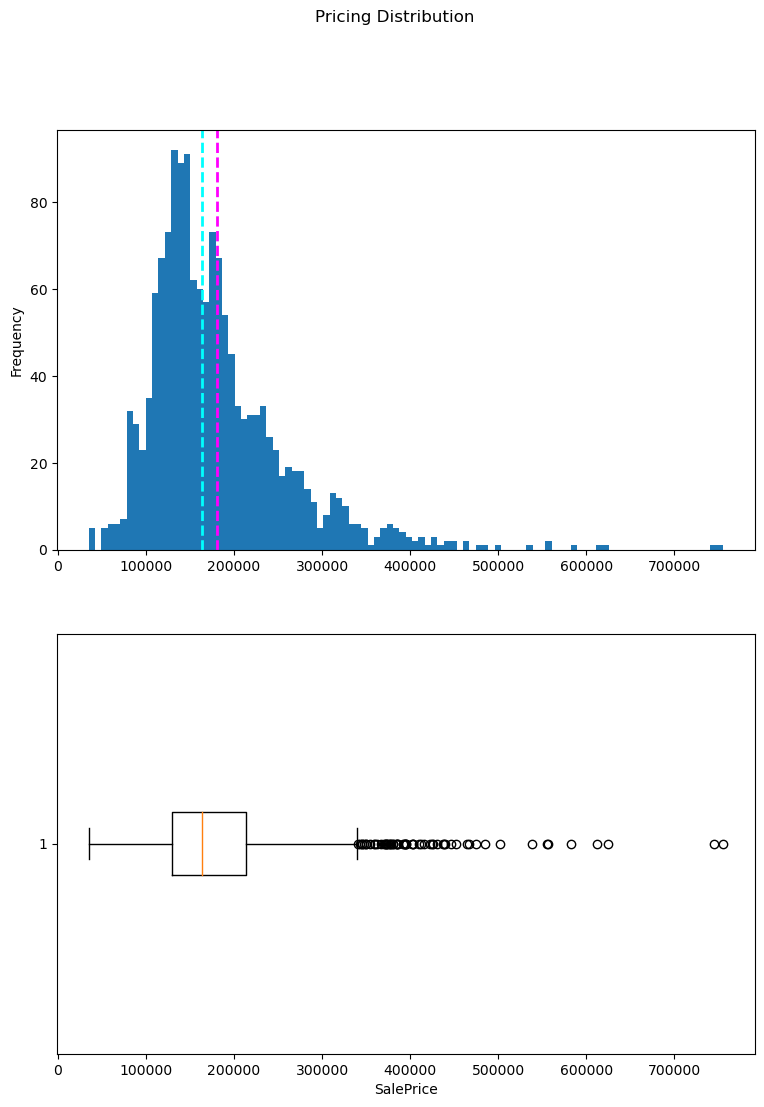

In [57]:
DataPlotter.plot_distribution(df, target='SalePrice', title='Pricing Distribution')

From these plots, we can observe that the majority of the data falls within the price range of USD30,000 to USD340,000, with the mean close to the middle of this range. Prices above USD340,000 appear to be unusual, indicating that they are **outliers**.

We will perform the same kind of exploration for the numeric features.

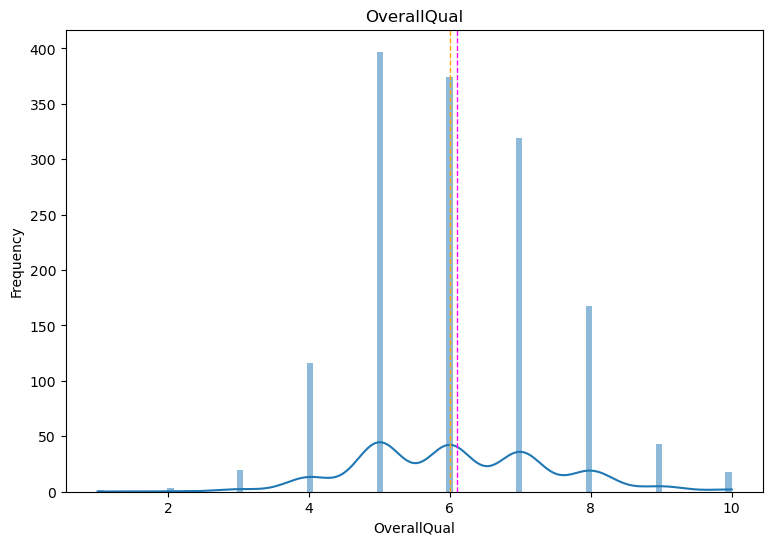

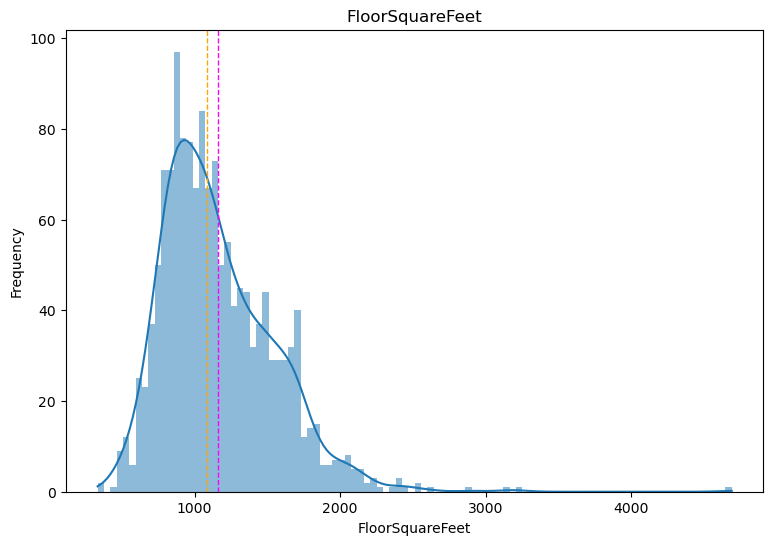

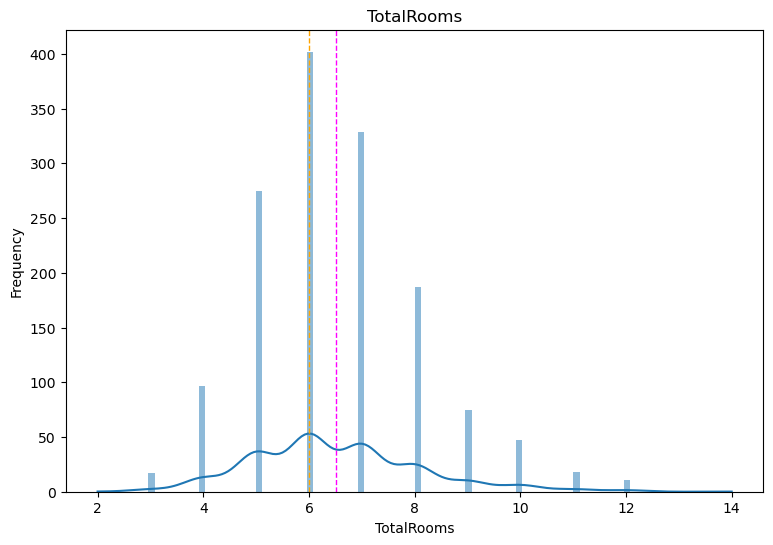

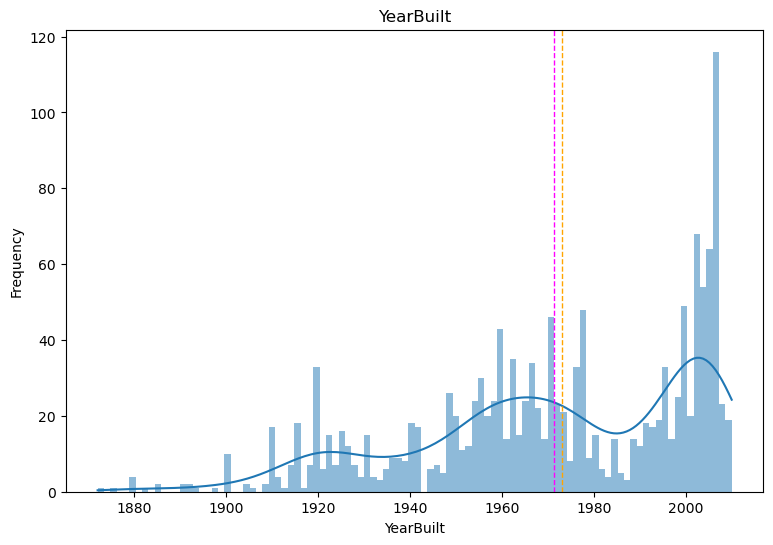

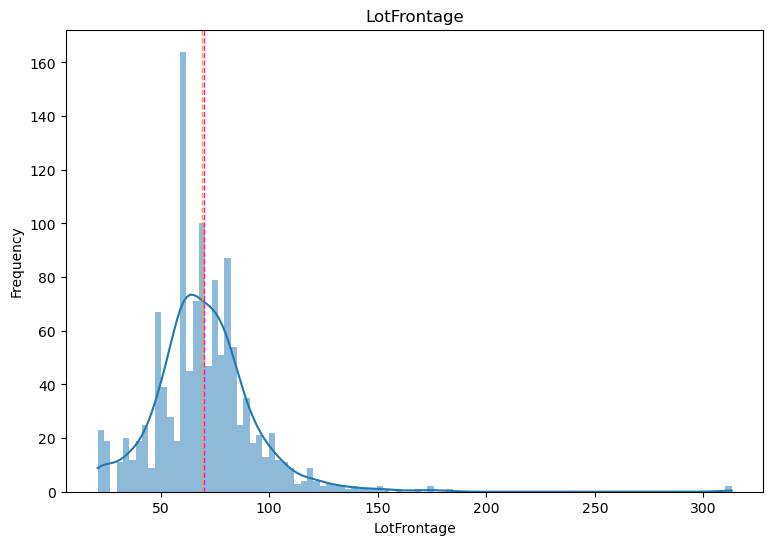

In [58]:
features = ['OverallQual','FloorSquareFeet','TotalRooms','YearBuilt','LotFrontage']

for col in features:
    DataPlotter.plot_features(df, feature=col)

As we can see, features seems to be more normally distributed than the label.

Now that we know more about the data in columns, we can analyze the relationship between the features and the label values. We can also calculate the correlation statistic to quantify the apparent relationship.

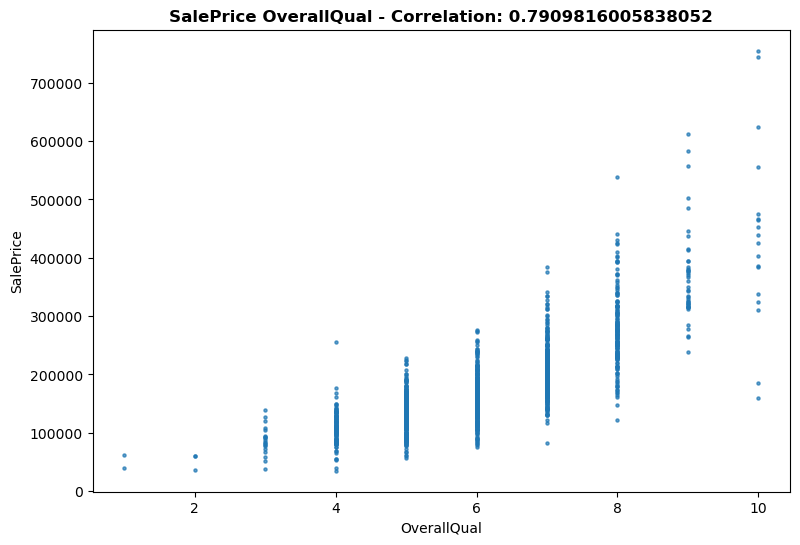

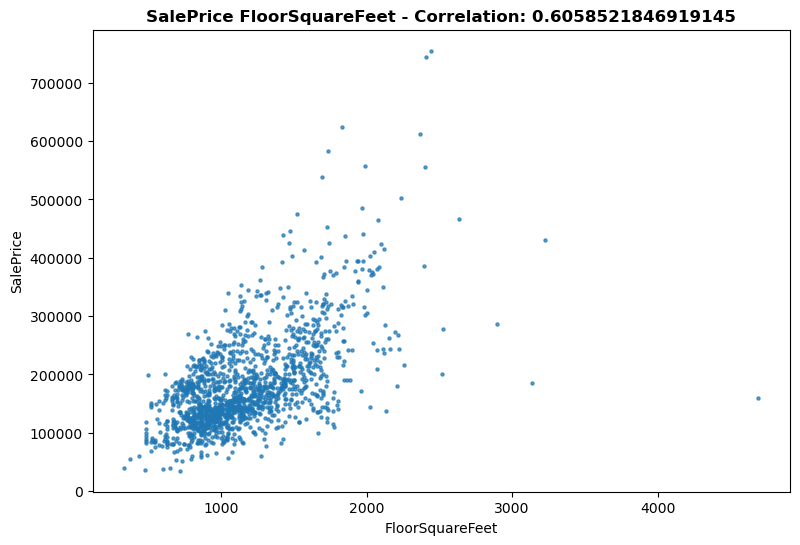

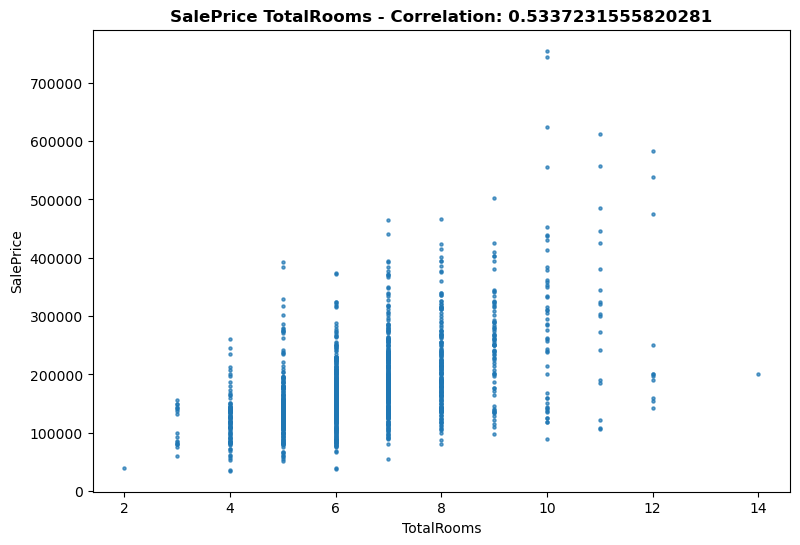

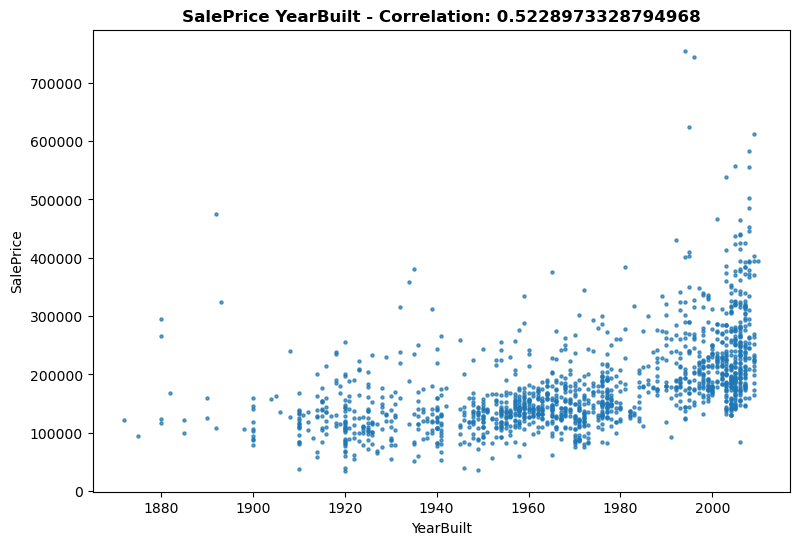

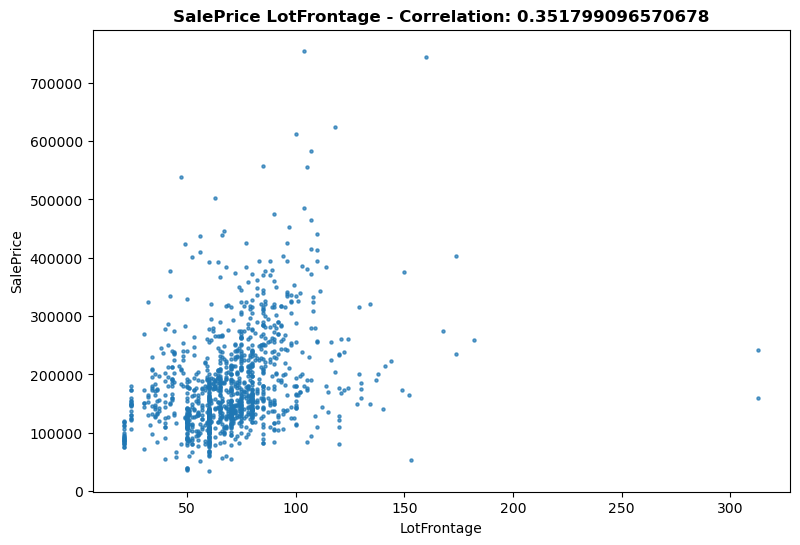

In [59]:
for col in features:
    DataPlotter.plot_correlation(df, feature=col, target='SalePrice')

Although the results may not seem very conclusive, a trend can be observed where the **OverallQual** rate coincides with high house prices. The same behavior is observed with the **FloorSquareFeet** of the property. In both cases, a correlation above 0.6 is observed, which indicates a positive correlation.

### Selected features

As OverallQual and FloorSquareFeet features have shown the strongest correlation with the target variable, we will be focusing on training and evaluating our model based on these features. o ensure consistency and clarity, we will be referring to them as **Feature 1** (**OverallQual**) and **Feature 2** (**FloorSquareFeet**) throughout the remainder of this project.

In [60]:
# Selected features
FEATURE1 = "OverallQual"
FEATURE2 = "FloorSquareFeet"

## Train the regression model

Now that we've explored the data, it's time to use it to train a regression model that uses the features we've identified as potentially predictive to predict the rentals label. The first thing we need to do is to separate the features we want to use to train the model from the label we want it to predict.

### Training on Feature 1

In [61]:
# Assign values to the label y - SalePrice
y = house_prices[:,0]

# Assign values to the feature X - OverallQual
X_f1 = house_prices[:,1]

# Split the data into training and testing sets
preprocess = PreprocessData()
X_train_f1, y_train_f1, X_test_f1, y_test_f1 = preprocess.split_data(X_f1, y, 0.8)

Total elements for X_train: 1168, X_test: 292
Total elements for y_train: 1168, y_test: 292


Now we're ready to train a model by fitting a uni-variate regression algorithm to the training data. We'll use a linear regression algorithm in order to find a linear relationship between the X values and the y label. The resulting model is a dictionary that conceptually defines a line where every possible X and y value combination intersect.

In [62]:
# Create an instance of the CustomModel class and train the model
model_f1 = CustomModel()
model_dict_f1, errors_f1 = model_f1.train(X_train_f1, y_train_f1, epochs=250, print_error_interval=25, alpha=0.001)

Epoch 25, error: 3505010784.469874
Epoch 50, error: 2865910185.938573
Epoch 75, error: 2854182234.443273
Epoch 100, error: 2851712436.38395
Epoch 125, error: 2849389749.6399484
Epoch 150, error: 2847079828.326528
Epoch 175, error: 2844780643.071024
Epoch 200, error: 2842492115.070592
Epoch 225, error: 2840214194.500343
Epoch 250, error: 2837946832.1880836


#### Error level analysis

As a result of the training function, we have obtained the error through the **Mean Squared Error (MSE)** function with the values calculated for the gradient descent at each iteration. These error values are shown in the following graph:

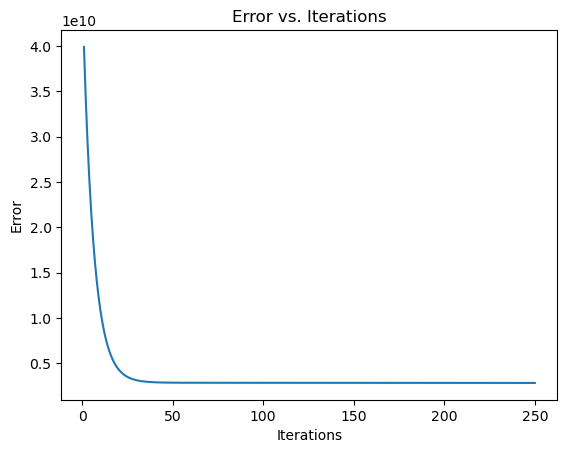

In [63]:
DataPlotter.plot_error(errors_f1)

As can be seen from the graph, as the weights were updated at each iteration, the calculation of the gradient descent improved the model, obtaining error measures that approach zero. **The lower the value, the better the model prediction will be.**

#### Model evolution in each epoch

In the following graph we can observe how the predictability of the model evolves in each iteration.

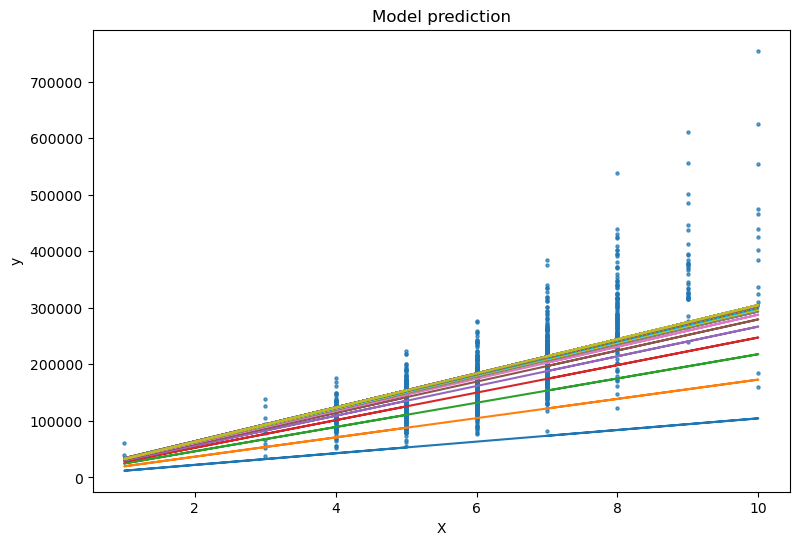

In [64]:
DataPlotter.plot_evolution(model_dict_f1,n=5,X=X_train_f1,y=y_train_f1)

### Training on Feature 2

In [65]:
# Assign values to the label y - SalePrice
y = house_prices[:,0]

# Assign values to the feature X - FloorSquareFeet
X_f2 = house_prices[:,2]

# Split the data into training and testing sets
X_train_f2, y_train_f2, X_test_f2, y_test_f2 = preprocess.split_data(X_f2, y, 0.8)

Total elements for X_train: 1168, X_test: 292
Total elements for y_train: 1168, y_test: 292


In [66]:
# Training the model with the data
model_f2 = CustomModel()
model_dict_f2, errors_f2 = model_f2.train(X_train_f2, y_train_f2, epochs=30, print_error_interval=10, alpha=0.001)

Epoch 10, error: 1.2710032317856399e+73
Epoch 20, error: 4.183909405795637e+142
Epoch 30, error: 1.377266200284354e+212


#### Error level analysis

As the evaluation for the Feature 1, we can observe how the obtained MSE changes with the values calculated for the gradient descent at each iteration. The errors and model prediction are shown in the following graphs:

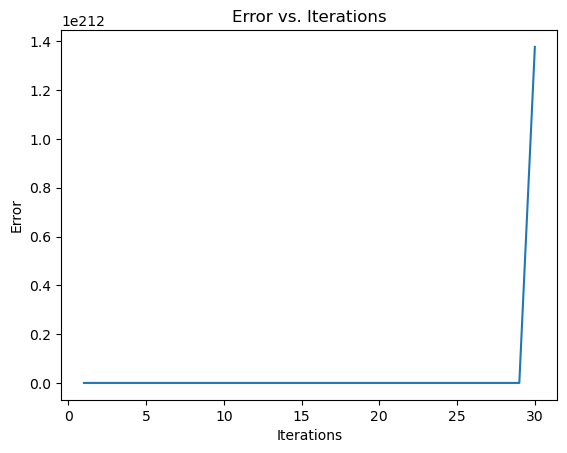

In [67]:
DataPlotter.plot_error(errors_f2)

#### Model evolution in each epoch

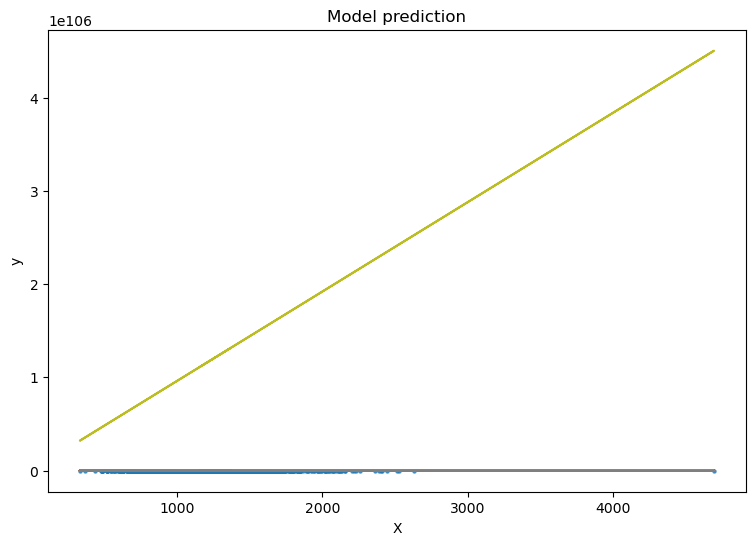

In [68]:
DataPlotter.plot_evolution(model_dict_f2,n=1,X=X_train_f2,y=y_train_f2)

#### Model validation

Unlike Feature 1, our model does not perform well on Feature 2. This is mainly because the data for this feature is affected by outliers, as we saw in the data exploration section. Since feature engineering is not the focus of this project, we did not apply techniques such as scaling and normalization to address this issue. However, we have developed a data transformation function to validate our model on this feature.

In [69]:
# Implementation for scaling and normalization feature

# Assign values to the feature X - FloorSquareFeet
X_f2_v2 = preprocess.scale_and_normalize(X_f2)

# Split the data into training and testing sets
X_train_f2_v2, y_train_f2_v2, X_test_f2_v2, y_test_f2_v2 = preprocess.split_data(X_f2_v2, y, 0.8)

Total elements for X_train: 1168, X_test: 292
Total elements for y_train: 1168, y_test: 292


In [70]:
# Training the model with the data
model_f2_v2 = CustomModel()
model_dict_f2_v2, errors_f2_v2 = model_f2_v2.train(X_train_f2_v2, y_train_f2_v2, epochs=5000, print_error_interval=500, alpha=0.001)

Epoch 500, error: 8678446846.190624
Epoch 1000, error: 4562055869.712764
Epoch 1500, error: 3998703363.8626556
Epoch 2000, error: 3921577758.541091
Epoch 2500, error: 3911015337.65825
Epoch 3000, error: 3909568342.731149
Epoch 3500, error: 3909370052.3388896
Epoch 4000, error: 3909342871.6624603
Epoch 4500, error: 3909339144.8640256
Epoch 5000, error: 3909338633.744991


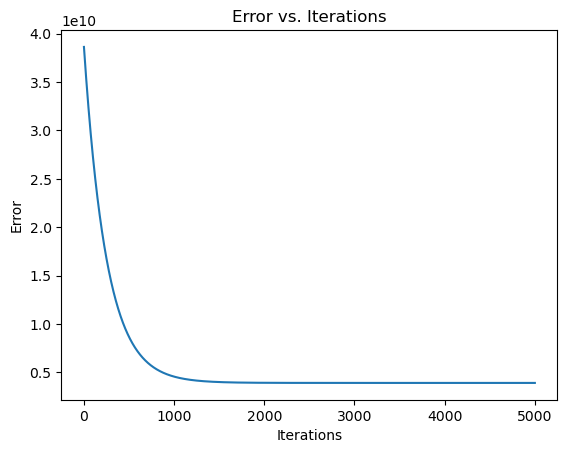

In [71]:
DataPlotter.plot_error(errors_f2_v2)

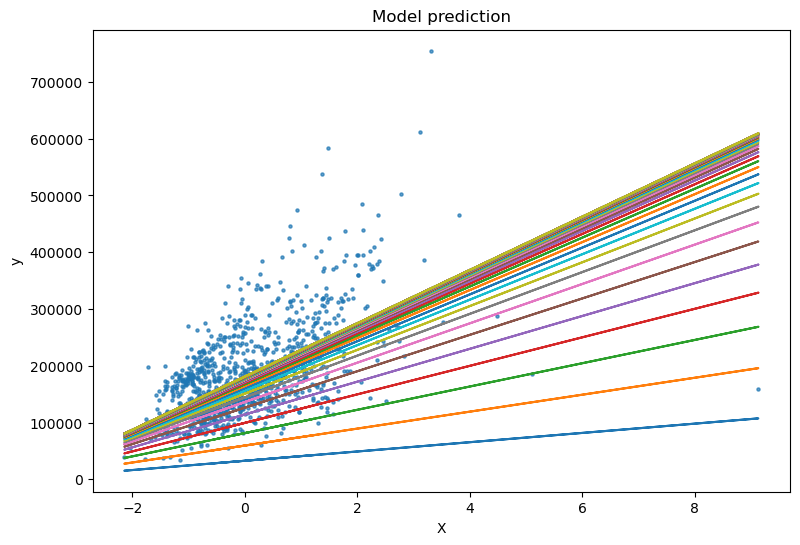

In [72]:
DataPlotter.plot_evolution(model_dict_f2_v2,n=100,X=X_train_f2_v2,y=y_train_f2_v2)

## Model evaluation

After training the model, we can use it to predict the sale price of houses using the features we reserved for our validation dataset. We can then compare these predictions to the actual label values to evaluate how well the model is performing.

### Evaluation of Feature 1

We can predict and obtain error metrics as follows:

In [73]:
custom_predictions_f1 = model_f1.predict_from_custom_model(model_dict_f1, X_test_f1, y_test_f1)

Metrics for the Custom Model:
MSE: 2830298129.231637
RMSE: 53200.54632455984
R2: 0.5375374445160017


We have calculated the level of error based on the following metrics from the predictions made:

* **Mean Square Error (MSE):** It measures the average squared differences between predicted and actual values. Smaller values indicate a better fit of the model.

* **Root Mean Square Error (RMSE):** It is the square root of the MSE and provides an absolute metric in the same unit as the label. The smaller the value, the better the model (in simple terms, it represents the average magnitude of prediction error).

* **Coefficient of Determination (R2):** It is a relative metric where higher values indicate a better fit of the model. This metric represents how much of the variance between predicted and actual label values the model can explain.

### Evaluation of Feature 2

In [74]:
custom_predictions_f2 = model_f2.predict_from_custom_model(model_dict_f2, X_test_f2, y_test_f2)

Metrics for the Custom Model:
MSE: 1.2524389881474095e+219
RMSE: 3.5389814751527163e+109
R2: -2.0658087277171384e+209


The results suggest that the linear regression model is not a good fit for the data. The mean squared error (MSE) is an extremely large value, which means that the predicted values are very far away from the actual values, on average. The root mean squared error (RMSE) is even larger than the MSE, which indicates that the errors are very large and the model is not fitting the data well at all. The R-squared value (R2) is also a negative value, which means that the model is performing worse than simply predicting the mean of the target variable.

Again, we can check with the transformed data to validate our model:

In [75]:
custom_predictions_f2_v2 = model_f2.predict_from_custom_model(model_dict_f2_v2, X_test_f2_v2, y_test_f2_v2)

Metrics for the Custom Model:
MSE: 4329074805.69789
RMSE: 65795.70507029991
R2: 0.37845926133531016


### Predictions vs actual labels

To analyze the results obtained from the predictions more efficiently, we can visualize them as a scatter plot that compares the predicted values with the actual values.

#### Predictions on Feature 1

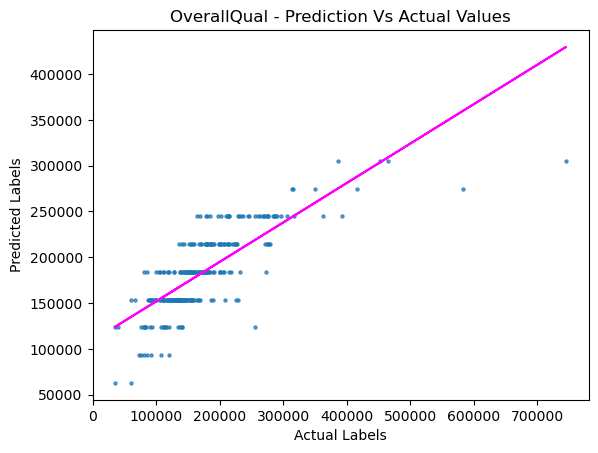

In [76]:
# Plot for the feature OverallQual
DataPlotter.plot_predictions(custom_predictions_f1,y_test_f1, title="OverallQual - Prediction Vs Actual Values")

As seen in the plot, there is a positive trend between the predicted values and the actual values, as indicated by the obtained error metrics. The predicted and actual values show a clear diagonal trend, with the intersections generally following the path of the trend line. However, there are noticeable differences between the ideal function represented by the line and the actual results. These differences are known as the residuals of the model. They represent the difference between the predicted label and the actual value of the validation label, when the model applies the coefficients learned during training to the validation data. 

#### Predictions on Feature 2

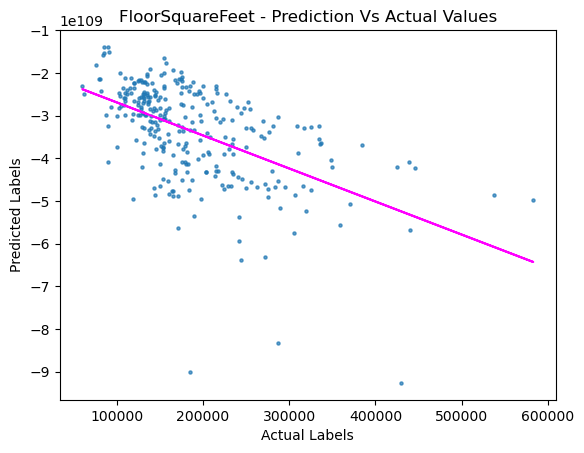

In [77]:
# Plot for the feature FloorSquareFeet
DataPlotter.plot_predictions(custom_predictions_f2,y_test_f2, title="FloorSquareFeet - Prediction Vs Actual Values")

In this graph, a poor performance of the model on the training set is observed, indicating a high level of variation between the predicted and actual values.

## Scikit-learn implementation

Since we have trained our model and analyzed the data manually, we will now use scikit-learn to train a linear regression model with the variables selected previously. Scikit-learn is a machine learning library in Python that provides a range of supervised and unsupervised learning algorithms through a consistent interface for building machine learning models.

It's important to mention that the methods used in the following implementation have been custom-made for the purpose of this project, and the implementation of the scikit-learn modules can be consulted in the **Experiment.py**.

### Implementation on the Feature 1

In [78]:
# Train the linear regression model 
skl_model_f1 = model_f1.train_with_skl(X_train_f1, y_train_f1)

Trained!


In [79]:
# Get the predictions
skl_predictions_f1 = model_f1.predict_from_skl_model(skl_model_f1, X_test_f1, y_test_f1)

Metrics for the Scikit-learn Model:
MSE: 2406587704.280572
RMSE: 49056.98425586893
R2: 0.6067705065331386


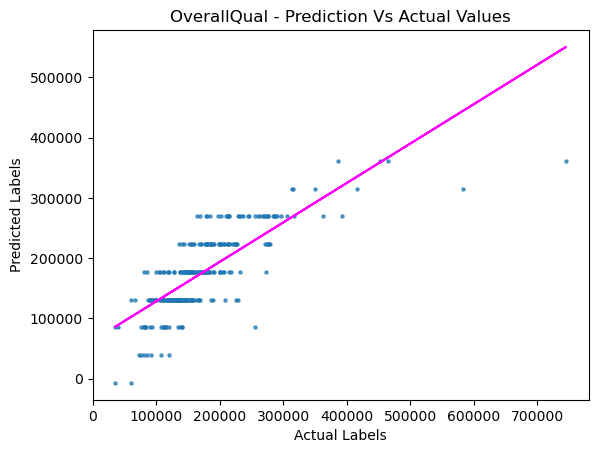

In [80]:
# Plot for the feature OverallQual
DataPlotter.plot_predictions(skl_predictions_f1,y_test_f1, title="OverallQual - Prediction Vs Actual Values")

### Implementation on the Feature 2

In [81]:
# Train the linear regression model 
skl_model_f2 = model_f2.train_with_skl(X_train_f2, y_train_f2)

Trained!


In [82]:
# Get the predictions
skl_predictions_f2 = model_f2.predict_from_skl_model(skl_model_f2, X_test_f2, y_test_f2)

Metrics for the Scikit-learn Model:
MSE: 4416142126.394277
RMSE: 66454.06027019174
R2: 0.2715888730804289


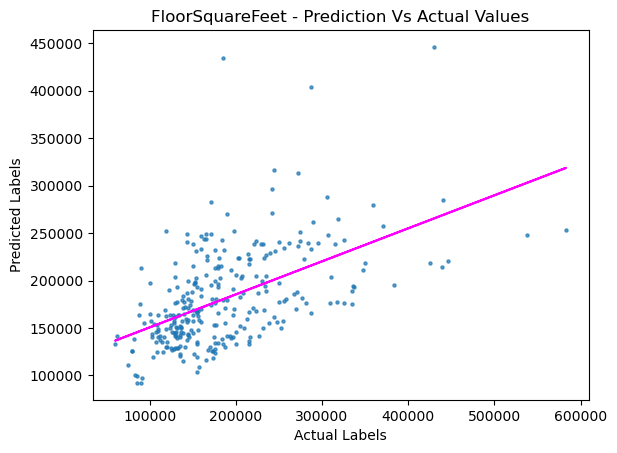

In [83]:
# Plot for the feature OverallQual
DataPlotter.plot_predictions(skl_predictions_f2,y_test_f2, title="FloorSquareFeet - Prediction Vs Actual Values")

## Average level of error between the models

After obtaining the predicted values from both the manual and scikit-learn models, we can calculate the average prediction by taking the mean of the two. This allows us to obtain a more robust prediction and reduce the impact of any potential bias in one of the models.

### Average predictions for the Feature 1

In [84]:
# Average for the OverallQual feature
avg_predictions_f1 = model_f1.evaluate_models(custom_predictions_f1, skl_predictions_f1, y_test_f1)

Metrics for the avg predictions:
MSE: 2480151112.0767655
RMSE: 49801.1155706051
R2: 0.5947504577587096


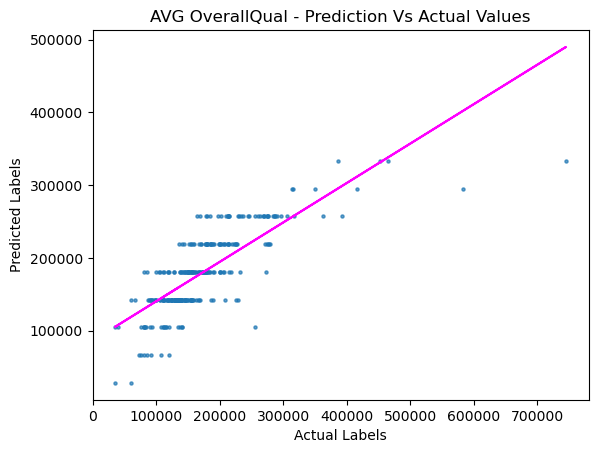

In [85]:
DataPlotter.plot_predictions(avg_predictions_f1,y_test_f1, title="AVG OverallQual - Prediction Vs Actual Values")

### Average predictions for the Feature 2

In [86]:
# Average for the OverallQual feature
avg_predictions_f2 = model_f2.evaluate_models(custom_predictions_f2, skl_predictions_f2, y_test_f2)

Metrics for the avg predictions:
MSE: 3.1310974703685238e+218
RMSE: 1.7694907375763582e+109
R2: -5.164521819292846e+208


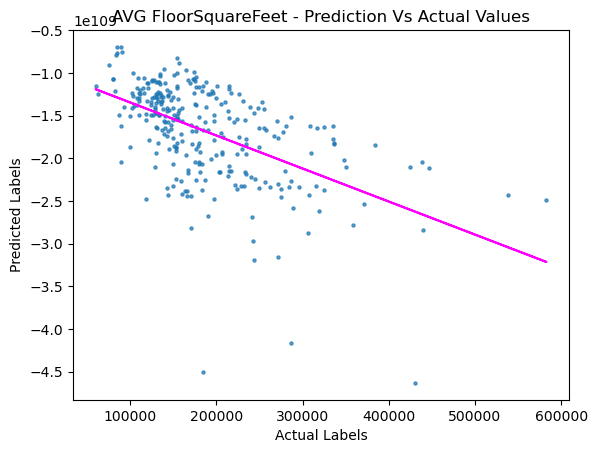

In [87]:
DataPlotter.plot_predictions(avg_predictions_f2,y_test_f2, title="AVG FloorSquareFeet - Prediction Vs Actual Values")

## Conclusion

Based on the procedure conducted, we conducted an analysis on a dataset with **SalePrice** as the target variable. To determine the most relevant features for the analysis, we identified the features with the highest correlation coefficients with the target variable, resulting in **OverallQual** and **FloorSquareFeet** as the top features.

To further analyze the impact of each feature on the target variable, we trained two different models for each feature. The first model was constructed manually, while the second model was a linear regression model developed through scikit-learn.

After evaluating the performance of our manually constructed linear regression model and the scikit-learn linear regression model on two features -FloorSquareFeet and OverallQual-, we found that the scikit-learn model outperformed our model for the **FloorSquareFeet** feature. We attribute this to the advanced preprocessing techniques implemented by scikit-learn. However, both models showed accurate results for the **OverallQual** feature. These results demonstrate the benefits of using a more advanced and automated approach in developing predictive models, such as the scikit-learn linear regression model.

## References

<sup>1</sup> Microsoft Ignite (2022). AI Automation Challenge Conference, Mexico City.
